<a href="https://colab.research.google.com/github/Kallol7/PytorchNotes/blob/main/Pretrained/Pretrained_Same_Domain.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction

  We are going to load a pre-trained model from Hugging Face and modify the model to detect dog breeds of 70 classes. Since the pre-trained model we are using this time is from the same domain (dog breed classification), we will go all in with 70 classes.

  

In [ ]:
import torch
from transformers import AutoModel, AutoFeatureExtractor, AutoModel, AutoConfig, AutoModelForImageClassification
import os

import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
import seaborn as sns

from PIL import Image
import albumentations as A
from tqdm import tqdm

import torch
from torch import nn
import torch.nn.functional as F

from torch.utils.data import DataLoader, Dataset
from torchvision import transforms as T

In [ ]:
# !pip install torcheval
from torcheval.metrics import MulticlassAccuracy, AUC

In [ ]:
# https://huggingface.co/wesleyacheng/dog-breeds-multiclass-image-classification-with-vit

from huggingface_hub import hf_hub_download

REPO_ID = "wesleyacheng/dog-breeds-multiclass-image-classification-with-vit"
FILENAME = "pytorch_model.bin"

model_path = hf_hub_download(repo_id=REPO_ID, filename=FILENAME, local_dir ="model")

In [4]:
# model_path = "/content/model/pytorch_model.pth"
checkpoint = torch.load(
    model_path, weights_only=False
)

In [5]:
model_path = "/content/model"
# os.rename(f"{model_path}/pytorch_model.pth", f"{model_path}/pytorch_model.bin")

In [140]:
model_config = AutoConfig.from_pretrained(REPO_ID)
# model_config

In [141]:
pretrained_model = AutoModelForImageClassification.from_pretrained(model_path, config = model_config)

In [142]:
# the pretrained model expects height=width=224
random_batch = torch.randn(5,3, 224, 224)
pretrained_model.eval()
pretrained_model(random_batch).logits.shape

torch.Size([5, 120])

In [143]:
len(list(pretrained_model.children()))

2

In [144]:
lenght_of_child_of_children = [len(list(child.children())) for child in pretrained_model.children()]
lenght_of_child_of_children

[3, 0]

In [145]:
# from google.colab import drive
# drive.mount('/content/drive')

In [146]:
# %%capture
# !unzip "/content/drive/MyDrive/Colab Notebooks/Dog Breed Classification/dog_breed.zip" -d "/content"

In [147]:
DATA_DIR = "/content/"
DEVICE = "cuda"
BATCH_SIZE = 32
HEIGHT, WIDTH = (224,224)
TOTAL_CLASS = 70
LR = 0.9e-4
EPOCHS = 18
MODEL_SAVE_PATH = "best.pt"

In [148]:
df = pd.read_csv("dogs.csv")
df.head(2)

,filepaths,labels,data set
0,train/Afghan/001.jpg,Afghan,train
1,train/Afghan/002.jpg,Afghan,train


In [149]:
# typo fix
df["labels"] = df["labels"].apply(lambda x: "American Spaniel" if x == "American  Spaniel" else x)

class_to_num = {label:name for (name,label) in enumerate(df["labels"].unique())}
class_name = {num:name for (name,num) in class_to_num.items()}

print("{")
for i in range(TOTAL_CLASS):
  print(f"  {i}: {class_name[i]}")
print("}")

{
  0: Afghan
  1: African Wild Dog
  2: Airedale
  3: American Hairless
  4: American Spaniel
  5: Basenji
  6: Basset
  7: Beagle
  8: Bearded Collie
  9: Bermaise
  10: Bichon Frise
  11: Blenheim
  12: Bloodhound
  13: Bluetick
  14: Border Collie
  15: Borzoi
  16: Boston Terrier
  17: Boxer
  18: Bull Mastiff
  19: Bull Terrier
  20: Bulldog
  21: Cairn
  22: Chihuahua
  23: Chinese Crested
  24: Chow
  25: Clumber
  26: Cockapoo
  27: Cocker
  28: Collie
  29: Corgi
  30: Coyote
  31: Dalmation
  32: Dhole
  33: Dingo
  34: Doberman
  35: Elk Hound
  36: French Bulldog
  37: German Sheperd
  38: Golden Retriever
  39: Great Dane
  40: Great Perenees
  41: Greyhound
  42: Groenendael
  43: Irish Spaniel
  44: Irish Wolfhound
  45: Japanese Spaniel
  46: Komondor
  47: Labradoodle
  48: Labrador
  49: Lhasa
  50: Malinois
  51: Maltese
  52: Mex Hairless
  53: Newfoundland
  54: Pekinese
  55: Pit Bull
  56: Pomeranian
  57: Poodle
  58: Pug
  59: Rhodesian
  60: Rottweiler
  61: 

In [150]:
df["labels"] = df["labels"].apply(lambda x:class_to_num[x])
df = df.iloc[:,:2]
df.head(3)

,filepaths,labels
0,train/Afghan/001.jpg,0
1,train/Afghan/002.jpg,0
2,train/Afghan/003.jpg,0


In [151]:
# only using 5 class
df = df[df["labels"]<TOTAL_CLASS]
df.head(3)
df.labels.unique()

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
       51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67,
       68, 69])

In [152]:
train_df, test_df = train_test_split(df, test_size=0.20, random_state=42, stratify=df["labels"])
len(train_df), len(test_df)

(7476, 1870)

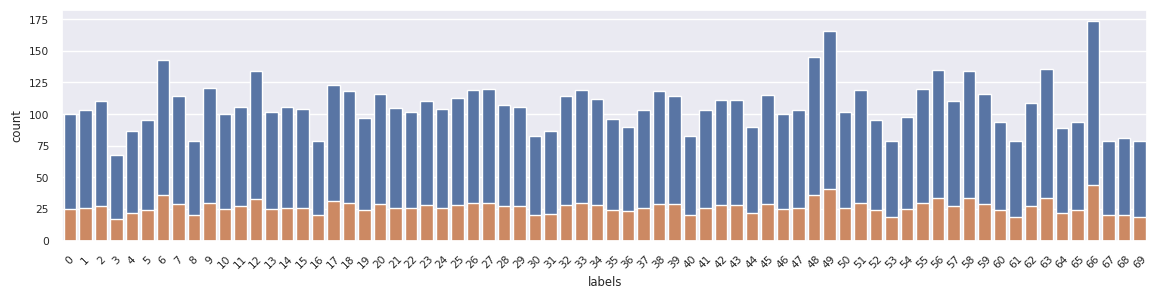

In [153]:
sns.set(font_scale = 0.7)
_, ax = plt.subplots(1,1, figsize=(14,3))
sns.countplot(data=train_df, x="labels", ax = ax)
sns.countplot(data=test_df, x="labels", ax=ax)
ax.tick_params(axis='x', labelrotation=45)
plt.show()
sns.reset_defaults()

# Sample Image

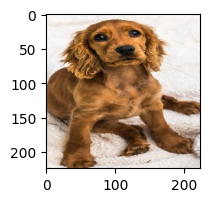

(224, 224, 3)

In [154]:
img = Image.open(os.path.join(DATA_DIR, train_df.iloc[9,0]))
_, ax = plt.subplots(1,1, figsize=(2,2))
ax.imshow(img)
plt.show()
np.shape(img)

# Augmentation

In [155]:
train_augms = A.Compose([
       A.Rotate(limit=(-75, 75)),
       A.HorizontalFlip(p=0.5),
       A.VerticalFlip(p=0.5),
       A.Rotate(limit=(-15, 15)),

       A.RandomResizedCrop(scale=(.7, 1.0), size=(HEIGHT, WIDTH)),
       A.ShiftScaleRotate(shift_limit=0.0625, scale_limit=0.1, rotate_limit=45, p=0.5),
       A.RandomBrightnessContrast(brightness_limit=0.2, contrast_limit=0.2, p=0.5),
       A.HueSaturationValue(hue_shift_limit=7, sat_shift_limit=7, val_shift_limit=7, p=0.5),
       A.CoarseDropout(max_holes=8, max_height=HEIGHT // 20, max_width=WIDTH // 20, min_holes=1, fill_value=0, p=0.5),  # New
       A.Normalize(mean=(.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))
   ])

valid_augms = A.Compose([
    A.Resize(height=HEIGHT, width=WIDTH),
    A.Normalize(mean = (.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))
])

def denorm(channel_first_tensor_image, permute=True):
  if permute:
    return channel_first_tensor_image.permute(1,2,0) * np.array((0.229, 0.224, 0.225)) + np.array((0.485, 0.456, 0.406))
  return channel_first_tensor_image * np.array((0.229, 0.224, 0.225)) + np.array((0.485, 0.456, 0.406))

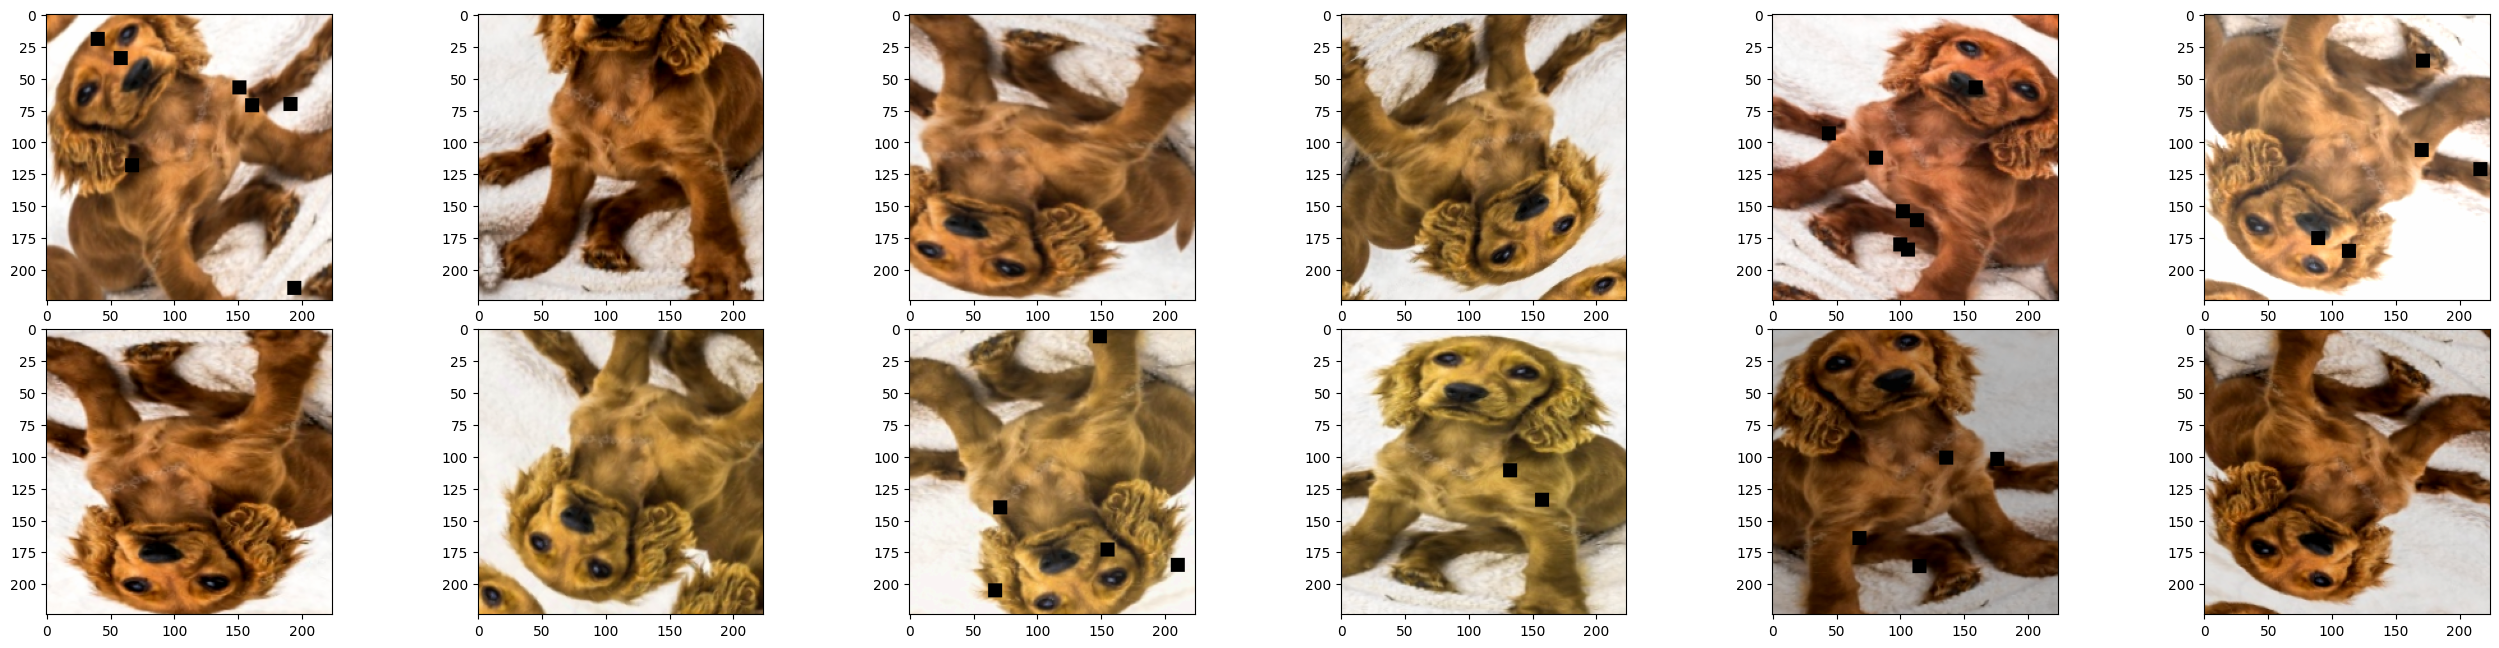

In [156]:
import logging

def show_image(img, aumentation = None, title = None, ax = None, plt_show = True, figsize=(8,8), normalize=True):
  logger = logging.getLogger()
  old_level = logger.level
  logger.setLevel(100)

  if ax is None:
    if aumentation is not None:
      _, axes = plt.subplots(2,6,figsize=figsize)
      plt.subplots_adjust(left=0, bottom=0, right=0.85, top=0.2, wspace=0.1, hspace=0.1)

      for ax in axes.flatten():
        augmented = aumentation(image = np.array(img))['image']
        if normalize:
          ax.imshow(augmented)
        else:
          ax.imshow(denorm(augmented, permute=False))
    else:
        plt.figure(figsize=(2,2))
        plt.imshow(img)

  else: # ax is provided
    ax.imshow( np.array(img) )

  if title is not None:
    if ax is None:
      plt.title(title)
    else:
      ax.set_title(title)

  if plt_show:
    plt.show()

  logger.setLevel(old_level)

show_image(img, train_augms, figsize=(30,30), normalize=False)

# Load Dateset

In [157]:
class ImageDataset(Dataset):
    def __init__(self, dataframe, directory, transforms=None):
        super().__init__()
        self.dataframe = dataframe
        self.data_dir = directory
        self.transforms = transforms

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, index):
        img_path = os.path.join(self.data_dir, self.dataframe.iloc[index, 0])
        image = Image.open(img_path)

        label = self.dataframe.iloc[index, 1]

        if self.transforms:
          image = self.transforms(image=np.array(image))['image']

        """Converts PIL or ndarray (H x W x C) range[0, 255]
        to a torch.FloatTensor (C x H x W) range [0.0, 1.0]"""
        image = T.ToTensor()(image)

        return image, label

In [158]:
# Create datasets
train_ds = ImageDataset(train_df, DATA_DIR, train_augms)
valid_ds = ImageDataset(test_df, DATA_DIR, valid_augms)

train_ds[43][0].shape, valid_ds[33][0].shape

(torch.Size([3, 224, 224]), torch.Size([3, 224, 224]))

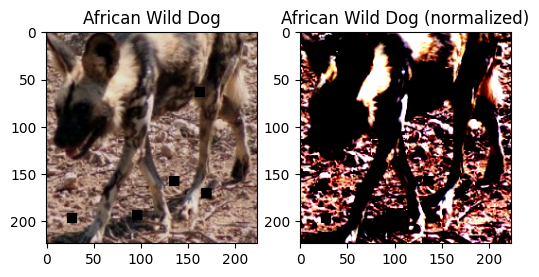

In [159]:
_channel_first_img,_label = train_ds[23]

_, ax = plt.subplots(1,2, figsize=(6,6))
ax = ax.flatten()

show_image(denorm(_channel_first_img), title = f"{class_name[_label]}", ax = ax[0], plt_show=False)
show_image(_channel_first_img.permute(1,2,0), title = f"{class_name[_label]} (normalized)", ax=ax[1])

In [160]:
print(f"Total training images {len(train_ds)}")
print(f"Total validation images {len(valid_ds)}")

Total training images 7476
Total validation images 1870


# Dataloader

In [161]:
train_dloader = DataLoader(train_ds, batch_size = BATCH_SIZE, shuffle=True)
valid_dloader = DataLoader(valid_ds, batch_size=BATCH_SIZE, shuffle=False)

print(f"Total batch in train loader : {len(train_dloader)}")
print(f"Total batch in valid loader : {len(valid_dloader)}")

Total batch in train loader : 234
Total batch in valid loader : 59


# Model

In [162]:
class Model(nn.Module):
  def __init__(self, pretrained, num_of_class = TOTAL_CLASS):
    super().__init__()

    self.hidden = pretrained
    del(pretrained)

    self.classifier = nn.Sequential(
        nn.Flatten(start_dim=1),
        nn.Linear(120, 96),
        # nn.BatchNorm1d(96),
        nn.ReLU(),
        nn.Dropout(0.5),

        nn.Linear(96, 86),
        # nn.BatchNorm1d(86),
        nn.ReLU(),
        nn.Dropout(0.2),

        nn.Linear(86, num_of_class)
    )

  def forward(self, images):
    x = self.hidden(images).logits
    x = self.classifier(x)

    return x

In [163]:
# https://spandan-madan.github.io/A-Collection-of-important-tasks-in-pytorch/

cnt = 1
for child in pretrained_model.children():
  if cnt<=1:
    print("child ",cnt," was frozen")
    for param in child.parameters():
      param.requires_grad = False
  elif cnt == 2:
    cnt_children_of_child = 1
    inner_cnt = len(list(child.children()))
    for children_of_child in child.children():
      if cnt_children_of_child < inner_cnt:
        for param in children_of_child.parameters():
          param.requires_grad = False
        print('child ', cnt_children_of_child, 'of child',cnt,' was frozen')
      else:
        print('child ', cnt_children_of_child, 'of child',cnt,' was not frozen')
      cnt_children_of_child += 1

  else:
    print("child ",cnt," was not frozen")
  cnt += 1

child  1  was frozen


In [164]:
model = Model(pretrained_model)
print(model(torch.randn(5,3, 224,224)).shape)

torch.Size([5, 70])


## Training & Validation Functions

In [165]:
def train_fn(dataloader, model, optimizer, criterion, device = DEVICE):
  model.train()
  total_loss = 0
  for images, labels in tqdm(dataloader, total = len(dataloader)):
    images = images.to(device)
    labels = labels.to(device)

    optimizer.zero_grad()

    logits = model(images)

    loss = criterion(logits, labels)
    total_loss += loss.item()

    loss.backward()
    optimizer.step()

  return total_loss/len(dataloader)

In [166]:
def evel_fn(dataloader, model, criterion, metric, device = DEVICE):
  model.eval()

  metric.reset()
  total_loss = 0

  for images, labels in tqdm(dataloader, total = len(dataloader)):
    images = images.to(device)
    labels = labels.to(device)

    logits = model(images)
    loss = criterion(logits, labels)
    metric.update(torch.argmax(logits, dim=-1), labels)
    total_loss += loss.item()

  return total_loss/len(dataloader), metric.compute().item()

# Training

In [167]:
%%capture
# "cuda", for gpu
# device = "cpu"

device = DEVICE # gpu
model.to(device)

In [168]:
# create the optimizer after moving to gpu
optimizer = torch.optim.Adam(model.parameters(), lr=LR)
criterion = nn.CrossEntropyLoss()
metric = MulticlassAccuracy(average = "macro", num_classes=70)

best_validation_loss = float("inf")
epoch = 0

# resume training
if os.path.exists(MODEL_SAVE_PATH):
  checkpoint = torch.load(MODEL_SAVE_PATH, weights_only=True)
  model.load_state_dict(checkpoint['model_state_dict'])
  optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
  epoch = checkpoint['epoch']
  best_validation_loss = checkpoint['best_validation_loss']

In [ ]:
for i in range(EPOCHS):
  if epoch % 10 == 0:
    for g in optimizer.param_groups:
      g["lr"] *= 0.8

  train_loss = train_fn(train_dloader, model, optimizer, criterion, device=device)
  validation_loss, macro_avg_accuracy = evel_fn(valid_dloader, model, criterion, metric, device=device)

  epoch += 1

  if validation_loss < best_validation_loss:
    best_validation_loss = validation_loss

    torch.save({
      'epoch': int(epoch),
      'model_state_dict': model.state_dict(),
      'optimizer_state_dict': optimizer.state_dict(),
      'best_validation_loss': best_validation_loss,
      'macro_avg_accuracy': macro_avg_accuracy
    }, MODEL_SAVE_PATH)

  print(f"Epoch: {epoch} Train_Loss: {train_loss:0.8f} Val_Loss: {validation_loss:0.8f}, Macro_Avg_Accuracy: {macro_avg_accuracy:0.8f}")

100%|██████████| 59/59 [00:22<00:00,  2.61it/s]


Epoch: 1 Train_Loss: 4.20688363 Val_Loss: 4.10832476, Macro_Avg_Accuracy: 0.20480186


100%|██████████| 59/59 [00:22<00:00,  2.63it/s]


Epoch: 2 Train_Loss: 4.01267366 Val_Loss: 3.67790313, Macro_Avg_Accuracy: 0.33906102


100%|██████████| 59/59 [00:22<00:00,  2.61it/s]


Epoch: 3 Train_Loss: 3.57035508 Val_Loss: 2.96405696, Macro_Avg_Accuracy: 0.43288028


100%|██████████| 59/59 [00:22<00:00,  2.62it/s]


Epoch: 4 Train_Loss: 3.10913034 Val_Loss: 2.34290279, Macro_Avg_Accuracy: 0.54248846


100%|██████████| 59/59 [00:22<00:00,  2.60it/s]


Epoch: 5 Train_Loss: 2.78078171 Val_Loss: 1.92677257, Macro_Avg_Accuracy: 0.61341530


100%|██████████| 59/59 [00:22<00:00,  2.61it/s]


Epoch: 6 Train_Loss: 2.55645085 Val_Loss: 1.62957334, Macro_Avg_Accuracy: 0.67818505


100%|██████████| 59/59 [00:22<00:00,  2.60it/s]


Epoch: 7 Train_Loss: 2.36883382 Val_Loss: 1.41381711, Macro_Avg_Accuracy: 0.70719552


100%|██████████| 59/59 [00:22<00:00,  2.61it/s]


Epoch: 8 Train_Loss: 2.26972644 Val_Loss: 1.26082379, Macro_Avg_Accuracy: 0.72739267


100%|██████████| 59/59 [00:22<00:00,  2.62it/s]


Epoch: 9 Train_Loss: 2.14873587 Val_Loss: 1.13152480, Macro_Avg_Accuracy: 0.74597913


100%|██████████| 59/59 [00:22<00:00,  2.62it/s]


Epoch: 10 Train_Loss: 2.05572877 Val_Loss: 1.03297827, Macro_Avg_Accuracy: 0.76857805


100%|██████████| 59/59 [00:22<00:00,  2.62it/s]


Epoch: 11 Train_Loss: 1.99635871 Val_Loss: 0.96624172, Macro_Avg_Accuracy: 0.78346902


100%|██████████| 59/59 [00:22<00:00,  2.63it/s]


Epoch: 12 Train_Loss: 1.96243973 Val_Loss: 0.91815553, Macro_Avg_Accuracy: 0.78294343


100%|██████████| 59/59 [00:22<00:00,  2.62it/s]


Epoch: 13 Train_Loss: 1.92637039 Val_Loss: 0.87038362, Macro_Avg_Accuracy: 0.79027385


100%|██████████| 59/59 [00:22<00:00,  2.62it/s]


Epoch: 14 Train_Loss: 1.87521175 Val_Loss: 0.82610927, Macro_Avg_Accuracy: 0.79771936


100%|██████████| 59/59 [00:22<00:00,  2.64it/s]


Epoch: 15 Train_Loss: 1.85297681 Val_Loss: 0.79382722, Macro_Avg_Accuracy: 0.80324256


100%|██████████| 59/59 [00:22<00:00,  2.63it/s]


Epoch: 16 Train_Loss: 1.81811100 Val_Loss: 0.76473117, Macro_Avg_Accuracy: 0.80945468


100%|██████████| 59/59 [00:22<00:00,  2.64it/s]


Epoch: 17 Train_Loss: 1.79598077 Val_Loss: 0.73287868, Macro_Avg_Accuracy: 0.81768703


 29%|██▉       | 69/234 [00:31<01:20,  2.04it/s]

In [ ]:
# Reload the best model
checkpoint = torch.load(MODEL_SAVE_PATH, map_location=device, weights_only=True)
model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

print(f"Epoch: {checkpoint['epoch']}, best_validation_loss: {best_validation_loss}, macro_avg_accuracy: {checkpoint['macro_avg_accuracy']}")